### FastSpecFit K-corrections

The purpose of this notebook is to illustrate how to compute custom K-corrections and rest-frame photometry using FastSpecFit model fitting results.

To load all the dependencies simply run (at NERSC):
```
source /dvs_ro/common/software/desi/desi_environment.sh main
module load fastspecfit/2.4.0
```

John Moustakas  
Siena College  
2023 August 19

#### Basic imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from fastspecfit.continuum import ContinuumTools
from fastspecfit.util import TabulatedDESI, C_LIGHT
from fastspecfit.io import read_fastspecfit, cache_templates, FLUXNORM
from fastspecfit._version import __version__
print(__version__)

2.4.0


#### Instantiate the cosmology, the continuum-fitting tools class, and the templates.

The `ContinuumTools` class loads the DR9 filter curves by default (see the [legacysurvey-dr9.yaml parameter file](https://github.com/desihub/fastspecfit/blob/main/py/fastspecfit/data/legacysurvey-dr9.yaml) for the full list of default parameters) and `TabulatedDESI` loads the fiducial DESI cosmology (documented [here](https://github.com/desihub/LSS/blob/main/py/LSS/tabulated_cosmo.py)). Some details regarding the SPS (stellar population synthesis) templates are documented [here](https://data.desi.lbl.gov/desi/public/external/templates/fastspecfit/README.txt).

In [3]:
cosmo = TabulatedDESI()
CTools = ContinuumTools()
templates = cache_templates()

#### Build and read a `fastspec` model.

As an initial simple example, let's fit a single galaxy. (Skip this section if you already have fitting results that you just want to read.)

In [4]:
from desispec.io import findfile
from fastspecfit.qa import fastqa
from fastspecfit.fastspecfit import fastspec

outdir = os.getenv('HOME')

survey, program, healpix = 'sv3', 'bright', 9813
targetid = 39633109787873428

redrockfile = findfile('redrock', survey=survey, faprogram=program, healpix=healpix, groupname='healpix', 
                       specprod_dir=os.path.join(os.getenv('DESI_SPECTRO_REDUX'), 'fuji'))
fastfile = os.path.join(outdir, f'fastspec-{targetid}.fits')
cmdargs = f'{redrockfile} --targetids {targetid} -o {fastfile}'
fastspec(args=cmdargs.split())

INFO:fastspecfit.py:120:parse: fastspec /global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv3/bright/98/9813/redrock-sv3-bright-9813.fits --targetids 39633109787873428 -o /global/homes/i/ioannis/fastspec-39633109787873428.fits
INFO:io.py:666:select: Reading and parsing 1 unique redrockfile(s).
INFO:io.py:721:select: specprod=fuji, coadd_type=healpix, survey=sv3, program=bright, healpix=9813
INFO:io.py:961:select: Gathered photometric metadata in 3.37 sec
INFO:io.py:1050:read_and_unpack: Reading 1 spectrum from /global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv3/bright/98/9813/coadd-sv3-bright-9813.fits
INFO:spectra.py:372:read_spectra: iotime 0.892 sec to read coadd-sv3-bright-9813.fits at 2023-08-19T09:25:06.296750
INFO:io.py:1084:read_and_unpack: Coadding across cameras took 0.01 seconds.
INFO:io.py:103:unpack_one_spectrum: Pre-processing object 0 [targetid 39633109787873428 z=0.132020].
INFO:fastspecfit.py:191:fastspec: Reading and unpacking 1 spectra to be fitted took 7.33 second

##### Generate and display the QA. 

Note that there's an issue with retrieving and writing the image cutouts to `$PSCRATCH`, although `$HOME`seems to work OK.

In [5]:
cmdargs = f'{fastfile} -o {outdir} --overwrite'
fastqa(args=cmdargs.split())

INFO:qa.py:1218:parse: fastspecfit-qa /global/homes/i/ioannis/fastspec-39633109787873428.fits -o /global/homes/i/ioannis --overwrite
INFO:io.py:1798:read_fastspecfit: Read 1 object(s) from /global/homes/i/ioannis/fastspec-39633109787873428.fits
INFO:qa.py:1304:fastqa: Building QA for 1 objects.
INFO:io.py:666:select: Reading and parsing 1 unique redrockfile(s).
INFO:io.py:721:select: specprod=fuji, coadd_type=healpix, survey=sv3, program=bright, healpix=9813
INFO:io.py:961:select: Gathered photometric metadata in 0.26 sec
INFO:io.py:1050:read_and_unpack: Reading 1 spectrum from /global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv3/bright/98/9813/coadd-sv3-bright-9813.fits
INFO:spectra.py:372:read_spectra: iotime 0.416 sec to read coadd-sv3-bright-9813.fits at 2023-08-19T09:25:17.627491
INFO:io.py:1084:read_and_unpack: Coadding across cameras took 0.01 seconds.
INFO:io.py:103:unpack_one_spectrum: Pre-processing object 0 [targetid 39633109787873428 z=0.132020].
INFO:qa.py:442:qa_fastspec

(-0.5, 2399.5, 1799.5, -0.5)

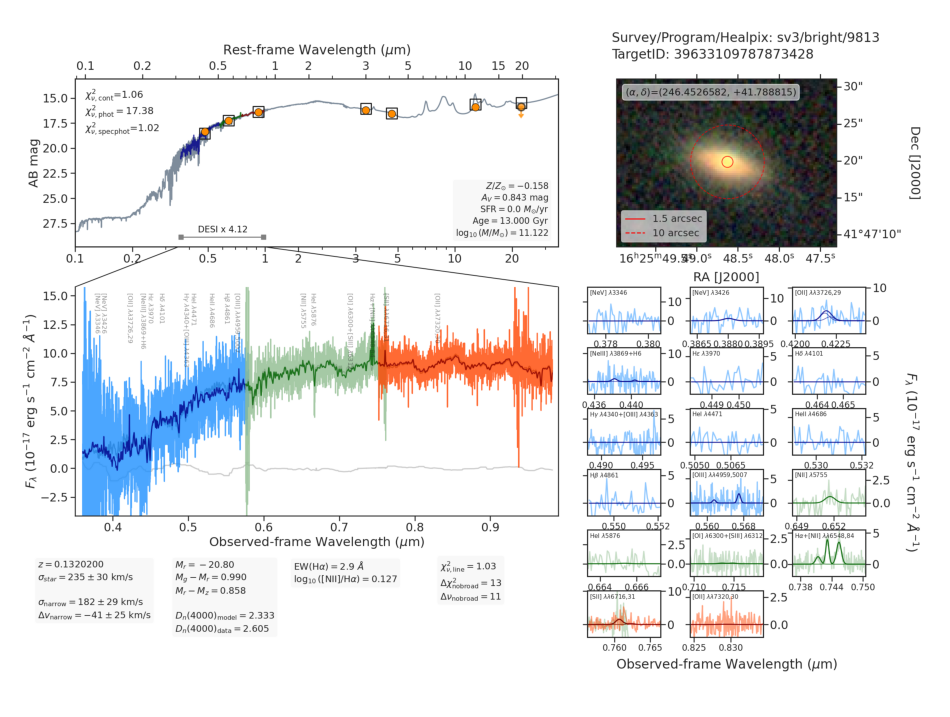

In [6]:
import matplotlib.image as mpimg
pngfile = os.path.join(outdir, f'fastspec-{survey}-{program}-{healpix}-{targetid}.png')
img = mpimg.imread(pngfile)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.axis('off')

##### Read the fitting results. Click [here](https://fastspecfit.readthedocs.io/en/latest/fastspec.html) for a description of the data model.

In [7]:
fast, meta, _, _ = read_fastspecfit(fastfile, read_models=False)
meta

INFO:io.py:1798:read_fastspecfit: Read 1 object(s) from /global/homes/i/ioannis/fastspec-39633109787873428.fits


TARGETID,SURVEY,PROGRAM,HEALPIX,TILEID_LIST,RA,DEC,COADD_FIBERSTATUS,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV1_SCND_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,Z,ZWARN,DELTACHI2,SPECTYPE,Z_RR,TSNR2_BGS,TSNR2_LRG,TSNR2_ELG,TSNR2_QSO,TSNR2_LYA,PHOTSYS,LS_ID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,EBV,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,SPECPROD
int64,str3,str6,int32,str3,float64,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,str6,float64,float32,float32,float32,float32,float32,str1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str4
39633109787873428,sv3,bright,9813,371,246.45265819296137,41.788815091413966,0,0,0,0,0,0,0,0,0,0,0,0,5764607523034234880,514,0,0,0,79164837199872,0.13201998015853975,0,1188.5740924547426,GALAXY,0.13201998015853975,1509.0891,16.381714,24.765764,5.803305,13.420705,N,9907735413461140,8.627236,23.981102,52.90357,8.796243,24.293858,53.282635,45.859978,126.65814,277.79364,329.8847,236.47246,440.48077,-262.35446,38.72847,9.974761,5.285672,0.8629126,0.39038897,0.0023887078,1.8650966e-05,0.0064652446,0.9807865,0.9871261,0.9928857,0.99890494,0.99932736,0.9998565,0.9999458,fuji


In [8]:
fast

TARGETID,SURVEY,PROGRAM,HEALPIX,Z,COEFF,RCHI2,RCHI2_CONT,RCHI2_PHOT,SNR_B,SNR_R,SNR_Z,SMOOTHCORR_B,SMOOTHCORR_R,SMOOTHCORR_Z,VDISP,VDISP_IVAR,AV,AGE,ZZSUN,LOGMSTAR,SFR,DN4000,DN4000_OBS,DN4000_IVAR,DN4000_MODEL,FLUX_SYNTH_G,FLUX_SYNTH_R,FLUX_SYNTH_Z,FLUX_SYNTH_SPECMODEL_G,FLUX_SYNTH_SPECMODEL_R,FLUX_SYNTH_SPECMODEL_Z,FLUX_SYNTH_PHOTMODEL_G,FLUX_SYNTH_PHOTMODEL_R,FLUX_SYNTH_PHOTMODEL_Z,FLUX_SYNTH_PHOTMODEL_W1,FLUX_SYNTH_PHOTMODEL_W2,FLUX_SYNTH_PHOTMODEL_W3,FLUX_SYNTH_PHOTMODEL_W4,ABSMAG10_DECAM_G,ABSMAG10_IVAR_DECAM_G,KCORR10_DECAM_G,ABSMAG10_DECAM_R,ABSMAG10_IVAR_DECAM_R,KCORR10_DECAM_R,ABSMAG10_DECAM_Z,ABSMAG10_IVAR_DECAM_Z,KCORR10_DECAM_Z,ABSMAG00_U,ABSMAG00_IVAR_U,KCORR00_U,ABSMAG00_B,ABSMAG00_IVAR_B,KCORR00_B,ABSMAG00_V,ABSMAG00_IVAR_V,KCORR00_V,ABSMAG01_SDSS_U,ABSMAG01_IVAR_SDSS_U,KCORR01_SDSS_U,ABSMAG01_SDSS_G,ABSMAG01_IVAR_SDSS_G,KCORR01_SDSS_G,ABSMAG01_SDSS_R,ABSMAG01_IVAR_SDSS_R,KCORR01_SDSS_R,ABSMAG01_SDSS_I,ABSMAG01_IVAR_SDSS_I,KCORR01_SDSS_I,ABSMAG01_SDSS_Z,ABSMAG01_IVAR_SDSS_Z,KCORR01_SDSS_Z,ABSMAG01_W1,ABSMAG01_IVAR_W1,KCORR01_W1,LOGLNU_1500,LOGLNU_2800,LOGL_1450,LOGL_1700,LOGL_3000,LOGL_5100,FLYA_1215_CONT,FOII_3727_CONT,FHBETA_CONT,FOIII_5007_CONT,FHALPHA_CONT,RCHI2_LINE,DELTA_LINECHI2,DELTA_LINENDOF,APERCORR,APERCORR_G,APERCORR_R,APERCORR_Z,NARROW_Z,NARROW_ZRMS,BROAD_Z,BROAD_ZRMS,UV_Z,UV_ZRMS,NARROW_SIGMA,NARROW_SIGMARMS,BROAD_SIGMA,BROAD_SIGMARMS,UV_SIGMA,UV_SIGMARMS,MGII_DOUBLET_RATIO,OII_DOUBLET_RATIO,SII_DOUBLET_RATIO,LYALPHA_MODELAMP,LYALPHA_AMP,LYALPHA_AMP_IVAR,LYALPHA_FLUX,LYALPHA_FLUX_IVAR,LYALPHA_BOXFLUX,LYALPHA_BOXFLUX_IVAR,LYALPHA_VSHIFT,LYALPHA_SIGMA,LYALPHA_CONT,LYALPHA_CONT_IVAR,LYALPHA_EW,LYALPHA_EW_IVAR,LYALPHA_FLUX_LIMIT,LYALPHA_EW_LIMIT,LYALPHA_CHI2,LYALPHA_NPIX,OI_1304_MODELAMP,OI_1304_AMP,OI_1304_AMP_IVAR,OI_1304_FLUX,OI_1304_FLUX_IVAR,OI_1304_BOXFLUX,OI_1304_BOXFLUX_IVAR,OI_1304_VSHIFT,OI_1304_SIGMA,OI_1304_CONT,OI_1304_CONT_IVAR,OI_1304_EW,OI_1304_EW_IVAR,OI_1304_FLUX_LIMIT,OI_1304_EW_LIMIT,OI_1304_CHI2,OI_1304_NPIX,SILIV_1396_MODELAMP,SILIV_1396_AMP,SILIV_1396_AMP_IVAR,SILIV_1396_FLUX,SILIV_1396_FLUX_IVAR,SILIV_1396_BOXFLUX,SILIV_1396_BOXFLUX_IVAR,SILIV_1396_VSHIFT,SILIV_1396_SIGMA,SILIV_1396_CONT,SILIV_1396_CONT_IVAR,SILIV_1396_EW,SILIV_1396_EW_IVAR,SILIV_1396_FLUX_LIMIT,SILIV_1396_EW_LIMIT,SILIV_1396_CHI2,SILIV_1396_NPIX,CIV_1549_MODELAMP,CIV_1549_AMP,CIV_1549_AMP_IVAR,CIV_1549_FLUX,CIV_1549_FLUX_IVAR,CIV_1549_BOXFLUX,CIV_1549_BOXFLUX_IVAR,CIV_1549_VSHIFT,CIV_1549_SIGMA,CIV_1549_CONT,CIV_1549_CONT_IVAR,CIV_1549_EW,CIV_1549_EW_IVAR,CIV_1549_FLUX_LIMIT,CIV_1549_EW_LIMIT,CIV_1549_CHI2,CIV_1549_NPIX,HEII_1640_MODELAMP,HEII_1640_AMP,HEII_1640_AMP_IVAR,HEII_1640_FLUX,HEII_1640_FLUX_IVAR,HEII_1640_BOXFLUX,HEII_1640_BOXFLUX_IVAR,HEII_1640_VSHIFT,HEII_1640_SIGMA,HEII_1640_CONT,HEII_1640_CONT_IVAR,HEII_1640_EW,HEII_1640_EW_IVAR,HEII_1640_FLUX_LIMIT,HEII_1640_EW_LIMIT,HEII_1640_CHI2,HEII_1640_NPIX,ALIII_1857_MODELAMP,ALIII_1857_AMP,ALIII_1857_AMP_IVAR,ALIII_1857_FLUX,ALIII_1857_FLUX_IVAR,ALIII_1857_BOXFLUX,ALIII_1857_BOXFLUX_IVAR,ALIII_1857_VSHIFT,ALIII_1857_SIGMA,ALIII_1857_CONT,ALIII_1857_CONT_IVAR,ALIII_1857_EW,ALIII_1857_EW_IVAR,ALIII_1857_FLUX_LIMIT,ALIII_1857_EW_LIMIT,ALIII_1857_CHI2,ALIII_1857_NPIX,SILIII_1892_MODELAMP,SILIII_1892_AMP,SILIII_1892_AMP_IVAR,SILIII_1892_FLUX,SILIII_1892_FLUX_IVAR,SILIII_1892_BOXFLUX,SILIII_1892_BOXFLUX_IVAR,SILIII_1892_VSHIFT,SILIII_1892_SIGMA,SILIII_1892_CONT,SILIII_1892_CONT_IVAR,SILIII_1892_EW,SILIII_1892_EW_IVAR,SILIII_1892_FLUX_LIMIT,SILIII_1892_EW_LIMIT,SILIII_1892_CHI2,SILIII_1892_NPIX,CIII_1908_MODELAMP,CIII_1908_AMP,CIII_1908_AMP_IVAR,CIII_1908_FLUX,CIII_1908_FLUX_IVAR,CIII_1908_BOXFLUX,CIII_1908_BOXFLUX_IVAR,CIII_1908_VSHIFT,CIII_1908_SIGMA,CIII_1908_CONT,CIII_1908_CONT_IVAR,CIII_1908_EW,CIII_1908_EW_IVAR,CIII_1908_FLUX_LIMIT,CIII_1908_EW_LIMIT,CIII_1908_CHI2,CIII_1908_NPIX,MGII_2796_MODELAMP,MGII_2796_AMP,MGII_2796_AMP_IVAR,MGII_2796_FLUX,MGII_2796_FLUX_IVAR,MGII_2796_BOXFLUX,MGII_2796_BOXFLUX_IVAR,MGII_2796_VSHIFT,MGII_2796_SIGMA,MGII_2796_CONT,MG

#### Reproduce the best-fitting model fit.

In [9]:
redshift = fast['Z'][0]
vdisp = fast['VDISP'][0]
photsys = meta['PHOTSYS'][0] # N/S photometric system
coeff = fast['COEFF'].flatten()
dlum = cosmo.luminosity_distance(redshift)
dmod = cosmo.distance_modulus(redshift)
filters = CTools.filters[photsys]

In [10]:
sedmodel, sedphot = CTools.templates2data(
    templates['templateflux'], templates['templatewave'],
    redshift=redshift, dluminosity=dlum, vdisp=vdisp, 
    photsys=photsys, synthphot=True, coeff=coeff)

sedwave = templates['templatewave'] * (1 + redshift)

# [1e-17 erg/s/cm2/A --> maggies]
abfactor = 10**(0.4 * 48.6) * sedwave**2 / (C_LIGHT * 1e13) / FLUXNORM
sedmodel_abmag = -2.5 * np.log10(sedmodel * abfactor) # AB mag

##### Parse the observed (input) photometry and then make a plot!

In [11]:
nanomaggies = np.array([meta['FLUX_{}'.format(band.upper())] for band in CTools.bands]).flatten()
ivarnanomaggies = np.array([meta['FLUX_IVAR_{}'.format(band.upper())] for band in CTools.bands]).flatten()

phot = CTools.parse_photometry(CTools.bands, maggies=nanomaggies, ivarmaggies=ivarnanomaggies,
                               nanomaggies=True, lambda_eff=filters.effective_wavelengths.value,
                               min_uncertainty=CTools.min_uncertainty)
phot

band,lambda_eff,nanomaggies,nanomaggies_ivar,flam,flam_ivar,abmag,abmag_ivar,abmag_brighterr,abmag_fainterr,abmag_limit
str2,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32
g,4815.9536351296665,45.859978,38.72847,2.152236280233112e-16,6.140062484443096e+34,18.346416,69095.46,0.0037910212,0.0038176817,0.0
r,6437.792829370577,126.65814,9.974761,3.3264409815835074e-16,2.615190483751843e+34,17.243418,135743.83,0.0027074201,0.0027209902,0.0
z,9229.657864493674,277.79364,5.285672,3.5495377294054666e-16,2.3223011466404976e+34,16.390694,346015.97,0.0016973539,0.0017026778,0.0
W1,34002.540444816936,329.8847,0.8629126,3.10570463886497e-17,4.864218111125391e+35,16.204094,79660.414,0.0035315375,0.003554662,0.0
W2,46520.07577118702,236.47246,0.39038897,1.1893794800698418e-17,3.262773796218799e+36,16.565548,18518.678,0.007299036,0.007398511,0.0
W3,128103.3789599012,440.48077,0.0023887078,2.9216385726787228e-18,2.738190623184853e+37,15.8901825,393.15906,0.04819446,0.052889887,0.0
W4,223752.7751557955,-262.35446,1.8650966e-05,-5.70390516649236e-19,3.935073574338542e+36,0.0,0.0,0.0,0.0,15.835801


Text(0, 0.5, 'AB mag')

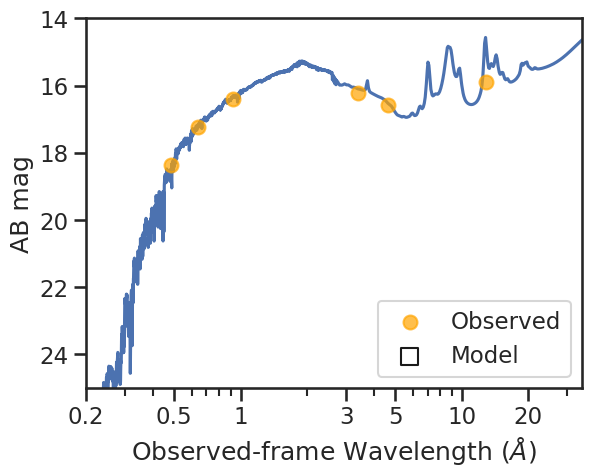

In [12]:
import matplotlib.ticker as ticker
sns.set(context='talk', style='ticks', font_scale=1.0)

@ticker.FuncFormatter
def major_formatter(x, pos):
    if (x >= 0.01) and (x < 0.1):
        return f'{x:.2f}'
    elif (x >= 0.1) and (x < 1):
        return f'{x:.1f}'
    else:
        return f'{x:.0f}'

fig, ax = plt.subplots()
ax.plot(sedwave / 1e4, sedmodel_abmag)
ax.scatter(phot['lambda_eff'] / 1e4, phot['abmag'], marker='o', s=100, 
           color='orange', zorder=2, alpha=0.7, label='Observed')
ax.scatter(sedphot['lambda_eff'] / 1e4, sedphot['abmag'], marker='s', s=150, 
           color='k', facecolor='none', zorder=3, label='Model')
ax.legend(loc='lower right')

ax.set_ylim(25, 14)
ax.set_xlim(0.2, 35)
ax.set_xscale('log')
ax.set_xticks(np.array([0.2, 0.5, 1.0, 3.0, 5.0, 10.0, 20.0]))
ax.xaxis.set_major_formatter(major_formatter)

ax.set_xlabel(r'Observed-frame Wavelength ($\AA$)')
ax.set_ylabel('AB mag')

#### What rest-frame photometry does FastSpecFit determine by default?

Note that each bandpass is band-shifted by an amount specified in the [legacysurvey-dr9.yaml parameter file](https://github.com/desihub/fastspecfit/blob/main/py/fastspecfit/data/legacysurvey-dr9.yaml).

In [13]:
for band, band_shift in zip(CTools.absmag_bands, CTools.band_shift):
    kcorr = fast['KCORR{:02d}_{}'.format(int(10*band_shift), band.upper())][0]
    mabs = fast['ABSMAG{:02d}_{}'.format(int(10*band_shift), band.upper())][0]
    print('{:7} (z={:.1f}): K={:.3f}, Mabs={:.3f}'.format(
           band, band_shift, kcorr, mabs))

decam_g (z=1.0): K=-5.091, Mabs=-14.748
decam_r (z=1.0): K=-2.188, Mabs=-17.652
decam_z (z=1.0): K=0.381, Mabs=-20.221
U       (z=0.0): K=-1.441, Mabs=-18.399
B       (z=0.0): K=0.118, Mabs=-19.958
V       (z=0.0): K=-0.225, Mabs=-20.718
sdss_u  (z=0.1): K=-2.045, Mabs=-17.794
sdss_g  (z=0.1): K=-0.031, Mabs=-19.809
sdss_r  (z=0.1): K=-0.144, Mabs=-20.799
sdss_i  (z=0.1): K=0.353, Mabs=-21.296
sdss_z  (z=0.1): K=-0.138, Mabs=-21.657
W1      (z=0.1): K=-0.152, Mabs=-21.830


##### But what if we want K-corrections to other rest-frame bandpasses? 

First, recompute K-corrections and rest-frame photometry to the same (default) bands and make sure we get consistent results.

In [14]:
from fastspecfit.continuum import restframe_photometry

absmag_filters = CTools.absmag_filters
band_shift = CTools.band_shift
    
kcorr, absmag, ivarabsmag, synth_absmag, synth_maggies_in = restframe_photometry(
    redshift=redshift, zmodelflux=sedmodel, zmodelwave=sedwave, 
    maggies=nanomaggies*1e-9, ivarmaggies=ivarnanomaggies*1e18, filters_in=filters, 
    absmag_filters=absmag_filters, band_shift=band_shift, dmod=dmod)

In [15]:
for iband, (band, band_shift) in enumerate(zip(CTools.absmag_bands, CTools.band_shift)):
    mabs = fast['ABSMAG{:02d}_{}'.format(int(10*band_shift), band.upper())][0]
    print('{:7} (z={:.1f}): Mabs(orig)={:.3f}, Mabs(new)={:.3f}, Mabs(synth)={:.3f}'.format(
           band, band_shift, mabs, absmag[iband], synth_absmag[iband]))

decam_g (z=1.0): Mabs(orig)=-14.748, Mabs(new)=-14.748, Mabs(synth)=-14.561
decam_r (z=1.0): Mabs(orig)=-17.652, Mabs(new)=-17.652, Mabs(synth)=-17.465
decam_z (z=1.0): Mabs(orig)=-20.221, Mabs(new)=-20.221, Mabs(synth)=-20.034
U       (z=0.0): Mabs(orig)=-18.399, Mabs(new)=-18.399, Mabs(synth)=-18.212
B       (z=0.0): Mabs(orig)=-19.958, Mabs(new)=-19.958, Mabs(synth)=-19.771
V       (z=0.0): Mabs(orig)=-20.718, Mabs(new)=-20.718, Mabs(synth)=-20.731
sdss_u  (z=0.1): Mabs(orig)=-17.794, Mabs(new)=-17.794, Mabs(synth)=-17.608
sdss_g  (z=0.1): Mabs(orig)=-19.809, Mabs(new)=-19.809, Mabs(synth)=-19.622
sdss_r  (z=0.1): Mabs(orig)=-20.799, Mabs(new)=-20.799, Mabs(synth)=-20.812
sdss_i  (z=0.1): Mabs(orig)=-21.296, Mabs(new)=-21.296, Mabs(synth)=-21.309
sdss_z  (z=0.1): Mabs(orig)=-21.657, Mabs(new)=-21.657, Mabs(synth)=-21.687
W1      (z=0.1): Mabs(orig)=-21.830, Mabs(new)=-21.830, Mabs(synth)=-21.986


##### Now choose different rest-frame bandpasses and band_shifts.

For example, let's do DECam `grz` and WISE `W1W2` band-shifted to `z=0.3`.

In [16]:
from speclite import filters as specfilters

myabsmag_filters = specfilters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z', 
                                            'wise2010-W1', 'wise2010-W2')
myband_shifts = [0.3] * len(myabsmag_filters)

mykcorr, myabsmag, myivarabsmag, mysynth_absmag, mysynth_maggies_in = restframe_photometry(
    redshift=redshift, zmodelflux=sedmodel, zmodelwave=sedwave, 
    maggies=nanomaggies*1e-9, ivarmaggies=ivarnanomaggies*1e18, filters_in=filters, 
    absmag_filters=myabsmag_filters, band_shift=myband_shifts, dmod=dmod)

for iband, (band, band_shift) in enumerate(zip(myabsmag_filters.names, myband_shifts)):
    print('{:7} (z={:.1f}): K={:.3f}, Mabs={:.3f}, Mabs(synth)={:.3f}'.format(
           band, band_shift, mykcorr[iband], myabsmag[iband], mysynth_absmag[iband]))

decam2014-g (z=0.3): K=-1.085, Mabs=-18.755, Mabs(synth)=-18.568
decam2014-r (z=0.3): K=-0.605, Mabs=-20.337, Mabs(synth)=-20.351
decam2014-z (z=0.3): K=-0.432, Mabs=-21.364, Mabs(synth)=-21.394
wise2010-W1 (z=0.3): K=0.001, Mabs=-21.983, Mabs(synth)=-22.139
wise2010-W2 (z=0.3): K=0.158, Mabs=-21.779, Mabs(synth)=-21.828


#### Your turn!